In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import scipy
from sklearn import linear_model

In [2]:
def load_pickles(path):
    pickle_file = pd.read_pickle(path)
    return pickle_file

def highest_reviews(restaurant_reviews_df):
    
    #Restaurant with highest number of reviews
    temp_df = pd.DataFrame(data = restaurant_reviews_df.groupby('business_id').size()).reset_index()
    temp_df.columns = ['business_id', 'number_of_reviews']
    ans = temp_df.nlargest(2,'number_of_reviews')    
    return ans

def groupby_date(restaurant_of_interest):
    year = []
    month = []
    for index, row in restaurant_of_interest.iterrows():
        split_date = row['date'].split('-')
        if int(split_date[0])>2012:
            year.append(split_date[0])
            month.append(split_date[1])

    year = pd.Series(year)
    month = pd.Series(month)
    hotel = pd.DataFrame()
    hotel['year'] = year.values
    hotel['month'] = month.values

    ans = hotel.groupby(['year', 'month']).size().reset_index()
    ans.columns = ['year', 'month','total_reviews']
    
    return ans

def create_train_test(restaurant_df):
    train_df = restaurant_df[restaurant_df['year']<'2017']
    test_df = restaurant_df[restaurant_df['year']=='2017']
    return train_df,test_df

def concatenate(df):
    year_month = []
    total_reviews=[]
    for index, row in df.iterrows():
        year_month.append(row['year']+'_'+row['month'])
        total_reviews.append(row['total_reviews'])
    year_month = pd.Series(year_month)
    total_reviews=pd.Series(total_reviews)
    df_new = pd.DataFrame()
    df_new['year-month']= year_month.values
    df_new['reviews']=total_reviews.values
    
    return df_new

def seasonal(train_df,test_df,pred_start,pred_end):
    
    season = 12
    df = pd.DataFrame()
    previous_reviews = train_df['total_reviews']
    predicted_reviews = []
    actual_reviews = []
    train_2016 = train_df[train_df['year']=='2016']
    test_2017 = test_df[test_df['year']=='2017']
    count2016 = 0
    count2017 = 0
    
    for index,row in train_2016.iterrows():
        count2016 += row['total_reviews']
    
    for index,row in test_2017.iterrows():
        count2017 += row['total_reviews']
        
    for index,row in test_df.iterrows():
        actual_reviews.append(float(row['total_reviews']/count2017))
    
    for index in range(pred_start,pred_end+1):
        predicted_reviews.append(float(previous_reviews[index-season]/count2016))
        
    df['predicted_reviews'] = predicted_reviews
    df['actual_reviews'] = actual_reviews
    return df

def emwa(train_df,test_df,alpha):
    
        #previous_reviews = train_df['total_reviews']
        #test_reviews = test_df['total_reviews']
        train_2016 = train_df[train_df['year']=='2016']
        test_2017 = test_df[test_df['year']=='2017']
        count2016 = 0
        count2017 = 0
    
        for index,row in train_2016.iterrows():
            count2016 += row['total_reviews']
    
        for index,row in test_2017.iterrows():
            count2017 += row['total_reviews']
            
        indices = np.arange(len(test_df))
        predicted_reviews = []
        predicted_reviews.append(int(train_df['total_reviews'].tail(1)))
        test_reviews = pd.DataFrame(test_df['total_reviews']).reset_index()
        for index in range(1,len(test_df)):
            predicted_reviews.append(alpha*int(test_reviews.iloc[index-1]['total_reviews']) + (1-alpha)*(int(predicted_reviews[index-1])))
            
        df = pd.DataFrame()
        
        pred_new = [float(x/count2016) for x in predicted_reviews]
        df['predicted_reviews'] = pred_new
        
        actual_new = []
        
        for index,row in test_df.iterrows():
            actual_new.append(float(row['total_reviews']/count2017))
        
        df['actual_reviews'] = actual_new
        return df
    
def average_error(actual_data, predicted_data,start,end):
    print('hi')
    average = 0
    for index in range(start,end):
        average = average + (abs(actual_data[index] - predicted_data[index]) / actual_data[index]) * 100
    average = average / len(actual_data)
    return average

def autoregression(actual_data, training_data_start, training_data_end, test_data_start, test_data_end, p,count2016):
    X_train, Y_train, X_test = [], [], []
    for index in range(training_data_start + p, training_data_end + 1):
        X_train.append(actual_data[index - p : index])
        Y_train.append(actual_data[index])

    predicted_data = []
    for index in range(test_data_start, test_data_end + 1):
        regr = linear_model.LinearRegression()
        regr.fit(X_train, Y_train)
        predicted_data.append(regr.predict([actual_data[index - p : index]])[0])
        X_train.append(actual_data[index - p : index])
        Y_train.append(actual_data[index])
    
    df = pd.DataFrame()
    predicted_data = [float(x/count2016) for x in predicted_data]
    df['predicted_reviews'] = predicted_data
    return df


In [3]:
#loading the pickle files
print("Loading the pickle files..")
reviews = load_pickles("C:/Users/tjnai/Downloads/reviews.pickle")
businesses = load_pickles("C:/Users/tjnai/Downloads/business.pickle")
business_categories = load_pickles("C:/Users/tjnai/Downloads/business_categories.pickle")

#Converting into dataframes
print("Converting them to dataframes..")
bcategories_df = pd.DataFrame(data=business_categories)
reviews_df = pd.DataFrame(data=reviews)

#Selecting only restaurants from all businesses
print("Finding restaurants..")
restaurants_df = pd.DataFrame(bcategories_df[bcategories_df['category_name'] == 'Restaurants'])

#Finding reviews of restaurants
restaurant_reviews = pd.merge(restaurants_df,reviews_df, on='business_id')

#Select columns
restaurant_reviews_df = restaurant_reviews[['business_id','date','review_id','stars','user_id']]

Loading the pickle files..
Converting them to dataframes..
Finding restaurants..


In [13]:
#bcategories_df

,business_id,category_name
0,FYWN1wneV18bWNgQjJ2GNg,Dentists
1,FYWN1wneV18bWNgQjJ2GNg,General Dentistry
2,FYWN1wneV18bWNgQjJ2GNg,Health & Medical
3,FYWN1wneV18bWNgQjJ2GNg,Oral Surgeons
4,FYWN1wneV18bWNgQjJ2GNg,Cosmetic Dentists
5,FYWN1wneV18bWNgQjJ2GNg,Orthodontists
6,He-G7vWjzVUysIKrfNbPUQ,Hair Stylists
7,He-G7vWjzVUysIKrfNbPUQ,Hair Salons
8,He-G7vWjzVUysIKrfNbPUQ,Men's Hair Salons
9,He-G7vWjzVUysIKrfNbPUQ,Blow Dry/Out Services


In [6]:
businesses_df = pd.DataFrame(data=businesses)
highest_reviews_df = highest_reviews(restaurant_reviews_df)

In [22]:
def time_series():
    
    restaurant_id = '4JNXUYY8wbaaDmk3BPzlWw'
    
    #Creating training and testing data
    restaurant_of_interest = restaurant_reviews_df[restaurant_reviews_df['business_id']==restaurant_id]
    ans = groupby_date(restaurant_of_interest)
    train_df,test_df = create_train_test(ans)
    train_df_concat = concatenate(train_df)

    #Seasonal time series
    df = seasonal(train_df,test_df,48,59).reset_index()
    df.columns = ['months','predicted_reviews','actual_Reviews']
    df_temp = df.iloc[0:4]
    plt = df_temp.plot(x='months',y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('Seasonal Time Series for Quarter-I')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[0:4],pred[0:4],0,4)
   
    
    print("Seasonal time series error : ",avg_error)

    #EMWA time series
    df = emwa(train_df,test_df,0.8)
    df.columns = ['predicted_reviews','actual_Reviews']
    #df = df.iloc[0:4]
    df_temp = df.iloc[8:12]
   
    plt = df_temp.plot(x=df_temp.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('EWMA Time Series (alpha=0.8) for Sept-Dec')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[8:12],pred[8:12],8,12)
    print("EWMA time series error : ",avg_error)
    

    train_2016 = train_df[train_df['year']=='2016']
    test_2017 = test_df[test_df['year']=='2017']
    count2016 = 0
    count2017 = 0

    for index,row in train_2016.iterrows():
        count2016 += row['total_reviews']

    for index,row in test_2017.iterrows():
        count2017 += row['total_reviews']
    
    
    #print("AutoRegression series")
    data = []
    for index,row in ans.iterrows():
        data.append(row['total_reviews'])
  
    df = autoregression(data,0,47,48,59,12,count2016)
    temp = []
    for index,row in test_df.iterrows():
        temp.append(float(row['total_reviews']/count2017))
        
    df['actual_Reviews']=temp
    df.columns = ['predicted_reviews','actual_Reviews']
    df_temp = df.iloc[8:12]
 
    
    plt = df_temp.plot(x=df_temp.index,y=['predicted_reviews','actual_Reviews'],ylim=[0,0.15])
    plt.set_title('AutoRegression Time Series (p=12) for Sept-Dec')
    plt.set_xlabel('Months')
    plt.set_ylabel('Predicted/Actual number of reviews')
    actual = df['actual_Reviews']
    pred = df['predicted_reviews']
    avg_error = average_error(actual[8:12],pred[8:12],8,12)
    print("Autoregression time series error : ",avg_error)
 
   

C:\Users\tjnai\Anaconda2\envs\py36\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


hi
Seasonal time series error :  10.541718530136865
hi
EWMA time series error :  65.68739833068273
hi
Autoregression time series error :  67.64057723647325


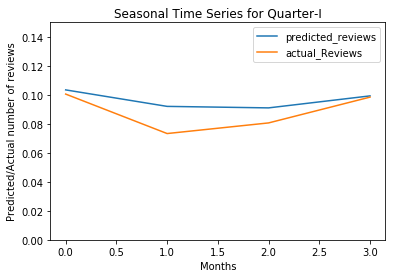

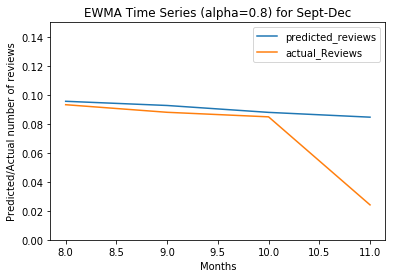

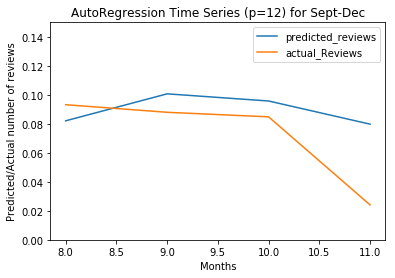

In [23]:
time_series()